In [4]:
from asyncio import base_tasks
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from models.dense_image_warp import dense_image_warp3d as warp
from scipy.ndimage import center_of_mass

# efficient center of mass calculation for 3d images along axis 1,2,3
def center_of_mass3d(img):
  mesh = tf.constant(np.meshgrid(np.arange(128), np.arange(128), np.arange(16), indexing='ij'), dtype=tf.float32)
  mesh = tf.expand_dims(tf.transpose(mesh, [1,2,3,0]), axis=0)
  return tf.reduce_sum(mesh * img, axis=(1,2,3)) / tf.reduce_sum(img, axis=(1,2,3))

def random_warp_t(img):

  X, Y, Z = np.meshgrid(np.arange(128), np.arange(128), np.arange(16), indexing='ij')
  mesh = tf.cast(tf.stack([X, Y, Z], axis=-1), tf.float32)

  centers = tf.reduce_sum(mesh * img, axis=(1,2,3)) / tf.reduce_sum(img, axis=(1,2,3))
  flow = tf.stack([tf.zeros_like(img[...,0]),
                  tf.zeros_like(img[...,0]),
                  tf.ones_like(img[...,0])*mesh[...,2] - centers[...,2]], axis=-1)
  flow /= tf.reduce_max(tf.abs(flow), axis=(1,2,3,4), keepdims=True)
  flow = flow * tf.cast(tf.random.uniform([1,], minval=0, maxval=4, dtype=tf.int32), tf.float32)
  flow = tf.cast(tf.cast(flow, tf.int32), tf.float32)

  return warp(img, flow, use_zeros=True)


def random_warp_mt(img):
  mesh = tf.constant(np.meshgrid(np.arange(128), np.arange(128), np.arange(16), indexing='ij'), dtype=tf.float32)
  mesh = tf.expand_dims(tf.transpose(mesh, [1,2,3,0]), axis=0)
  centers = tf.reduce_sum(mesh * img, axis=(1,2,3)) / tf.reduce_sum(img, axis=(1,2,3))
  # create a flow that has values [0,0,1] in last dimension everywhere if axis 3 index is bigger than center[:, 2] and [0,0,1] otherwise
  flow = tf.stack([tf.zeros_like(mesh[...,0]),
                   tf.zeros_like(mesh[...,1]),
                   mesh[...,2] - centers[...,2]], axis=-1)
                  #  tf.where(mesh[...,2] > centers[:,2],
                  #           tf.ones_like(mesh[...,2]),
                  #           tf.ones_like(mesh[...,2])*-1)], axis=-1)

  #flow = mesh - centers[:, None, None, None, :]
  #flowz = flow[..., 2]
  #flow = tf.zeros_like(flow[..., :2])
  #flow = tf.concat([flow, flowz[..., None]], axis=-1)
  flow /= tf.reduce_max(tf.abs(flow), axis=(1,2,3,4), keepdims=True)
  #flow = flow / tf.reduce_max(tf.norm(flow, axis=-1, keepdims=True), axis=(1,2,3,4), keepdims=True)
  # random integer in range [-5, 5]



  flow = flow * tf.cast(tf.random.uniform([1,], minval=0, maxval=4, dtype=tf.int32), tf.float32)
  flow = tf.cast(tf.cast(flow, tf.int32), tf.float32)
  #make
  print(flow.shape)
  plt.figure(figsize=(10,10))
  plt.imshow(montage(flow[0, ..., 2].numpy().transpose(2,0,1)))
  plt.colorbar()

  return warp(img, flow, use_zeros=True)


def create_vector_field(shape):
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    z = np.arange(shape[2])
    X, Y, Z = np.meshgrid(x, y, z)
    return np.stack([X, Y, Z], axis=-1)

def get_y_vec(img, axis=None):
    n = img.shape[axis]
    s = [1] * img.ndim
    s[axis] = -1
    i = np.arange(n).reshape(s)
    return np.sum(img * i, axis=axis) / np.sum(img, axis=axis)


############################################ DATA AUGMENTATION ############################################

class Center_of_Scalar:
    def __init__(self, shape):
      X, Y, Z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
      self.mesh = tf.cast(tf.stack([X, Y, Z], axis=-1), tf.float32)

    def __call__(self, img):
      centers = tf.reduce_sum(self.mesh * img, axis=(1,2,3)) / tf.reduce_sum(img, axis=(1,2,3))
      return centers

    def get_mesh(self):
      return self.mesh


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42, volume_shape=(128, 128, 16), **kwargs):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_batch = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=None),
      tf.keras.layers.experimental.preprocessing.RandomRotation(1, seed=None),
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, seed=None)
    ])
    self.CoS = Center_of_Scalar(volume_shape)
    self.volume_shape = volume_shape

  def expand_z_image_flow(self, img, flow):
    nx, ny, _ = self.volume_shape
    mean = tf.math.reduce_mean(img, axis=[1,2,3], keepdims=True)
    mean = tf.repeat(mean, nx, axis=1)
    mean = tf.repeat(mean, ny, axis=2)
    zeros = tf.zeros_like(flow)
    zeros = tf.reduce_sum(zeros, axis=-2, keepdims=True)
    img = tf.concat([mean, img, mean], axis=3)
    flow  = tf.concat([zeros, flow, zeros], axis=3)

    return img, flow

  def random_warp_z(self, img):

    centers = self.CoS(img)
    mesh = self.CoS.get_mesh()

    flow = tf.stack([tf.zeros_like(img[...,0]),
                    tf.zeros_like(img[...,0]),
                    tf.ones_like(img[...,0])*mesh[...,2] - centers[...,2]], axis=-1)
    flow /= tf.reduce_max(tf.abs(flow), axis=(1,2,3,4), keepdims=True)
    flow = flow * tf.cast(tf.random.uniform([1,], minval=0, maxval=4, dtype=tf.int32), tf.float32)
    flow = tf.cast(tf.cast(flow, tf.int32), tf.float32)

    img, flow = self.expand_z_image_flow(img, flow)

    return warp(img, flow)[..., 1:-1, :]

  def call(self, inputs, labels):
    ## unstack 2 batched inputs shape (batch, 128, 128, 16, 1) each in axis -2, and stack them back after augmentation
    ## unstack batched labels shape (batch, 5, 128, 128, 16, 1) each in axis -2 and -5, and stack them back after augmentation
    ## concat after unstacking to generate one big batch
    nz = labels.shape[-2]
      
    augmented = self.augment_batch(tf.concat(
      [tf.concat(tf.unstack(inputs['input_1'], axis=-2), axis=-1),
      tf.concat(tf.unstack(inputs['input_2'], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,0], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,1], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,2], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,3], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,4], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,5], axis=-2), axis=-1),
      tf.concat(tf.unstack(labels[:,6], axis=-2), axis=-1)], 
      axis=-1
    ))

    trgt_sz = tf.random.uniform(shape=[1,], minval=0.8, maxval=1.2) * 128
    trgt_sz = tf.cast(trgt_sz, tf.int32)[0]
    augmented = tf.image.resize_with_crop_or_pad(augmented, trgt_sz, trgt_sz)
    augmented = tf.image.resize(augmented, [128, 128])

    input1 = augmented[...,:nz]
    input2 = augmented[...,nz:2*nz]
    label4 = augmented[...,5*nz:6*nz]

    gamma = tf.random.uniform(shape=[1,], minval=0.7, maxval=1.3)[0]
    input1 = tf.image.adjust_gamma(input1, gamma=gamma)
    input2 = tf.image.adjust_gamma(input2, gamma=gamma)

    contrast = tf.random.uniform(shape=[1,], minval=0.7, maxval=1.3)[0]
    input1 = tf.image.adjust_contrast(input1, contrast_factor=contrast)
    input2 = tf.image.adjust_contrast(input2, contrast_factor=contrast)

    input1 = tf.expand_dims(tf.stack(tf.unstack(input1, axis=-1), axis=-1), axis=-1)
    input2 = tf.expand_dims(tf.stack(tf.unstack(input2, axis=-1), axis=-1), axis=-1)
    label4 = tf.expand_dims(tf.stack(tf.unstack(label4, axis=-1), axis=-1), axis=-1)

    input2 = self.random_warp_z(input2)

    axes = [1, 2, 3]
    mean = tf.reduce_mean(input1, axis=axes, keepdims=True)
    std = tf.math.reduce_std(input1, axis=axes, keepdims=True) + 1e-8
    input1 = (input1 - mean) / std
    mean = tf.reduce_mean(input2, axis=axes, keepdims=True)
    std = tf.math.reduce_std(input2, axis=axes, keepdims=True) + 1e-8
    input2 = (input2 - mean) / std

    inputs['input_1'] = input1
    inputs['input_2'] = input2

    labels = tf.stack([
      input1,
      input2,
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,4*nz:5*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,5*nz:6*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,6*nz:7*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,7*nz:8*nz], axis=-1), axis=-1), axis=-1),
      tf.expand_dims(tf.stack(tf.unstack(augmented[...,8*nz:9*nz], axis=-1), axis=-1), axis=-1)
    ], axis=1)
                        
    return inputs, labels




############################################ DATA LOADING ############################################

def parse_function(example_proto):
    feature_description = {
        'V0': tf.io.FixedLenFeature([], tf.string),
        'Vt': tf.io.FixedLenFeature([], tf.string),
        'M0': tf.io.FixedLenFeature([], tf.string),
        'Mt': tf.io.FixedLenFeature([], tf.string),
        'resx': tf.io.FixedLenFeature([], tf.string),
        'resy': tf.io.FixedLenFeature([], tf.string),
        'resz': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    V0 = tf.io.decode_raw(parsed_features['V0'], tf.float32)
    Vt = tf.io.decode_raw(parsed_features['Vt'], tf.float32)
    M0 = tf.io.decode_raw(parsed_features['M0'], tf.float32)
    Mt = tf.io.decode_raw(parsed_features['Mt'], tf.float32)
    resx = tf.io.decode_raw(parsed_features['resx'], tf.float32)
    resy = tf.io.decode_raw(parsed_features['resy'], tf.float32)
    resz = tf.io.decode_raw(parsed_features['resz'], tf.float32)
    V0 = tf.reshape(V0, [128, 128, 16, 1])
    Vt = tf.reshape(Vt, [128, 128, 16, 1])
    M0 = tf.reshape(M0, [128, 128, 16, 1])
    Mt = tf.reshape(Mt, [128, 128, 16, 1])
    resx = tf.reshape(resx, [128, 128, 16, 1])
    resy = tf.reshape(resy, [128, 128, 16, 1])
    resz = tf.reshape(resz, [128, 128, 16, 1])

    x = {'input_1': V0, 'input_2': Vt}
    y = tf.stack([V0, Vt, M0, Mt, resx, resy, resz], axis=0)

    return x,y

def load_tfrecord(filename):
    raw_dataset = tf.data.TFRecordDataset(filename)
    parsed_dataset = raw_dataset.map(parse_function)
    return parsed_dataset


dataset = load_tfrecord('data/training/trainingEDES_con_res.tfrecord')

# shuffle and batch
dataset = (
    dataset
    .cache()
    # .shuffle(50)
    .batch(1)
    .map(Augment(volume_shape=(128, 128, 16)))
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))


OperatorNotAllowedInGraphError: in user code:

    /var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_1607/824845460.py:174 call  *
        input2 = self.random_warp_z(input2)
    /var/folders/39/9622jvw14cxg_gy0jc2cxn_80000gn/T/ipykernel_1607/4018263046.py:130 random_warp_z  *
        img, flow = self.expand_z_image_flow(img, flow)
    /Users/yhibo/miniforge3/envs/pi/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:520 __iter__
        self._disallow_iteration()
    /Users/yhibo/miniforge3/envs/pi/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:516 _disallow_iteration
        self._disallow_in_graph_mode("iterating over `tf.Tensor`")
    /Users/yhibo/miniforge3/envs/pi/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:494 _disallow_in_graph_mode
        raise errors.OperatorNotAllowedInGraphError(

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


2022-10-26 00:46:52.335721: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


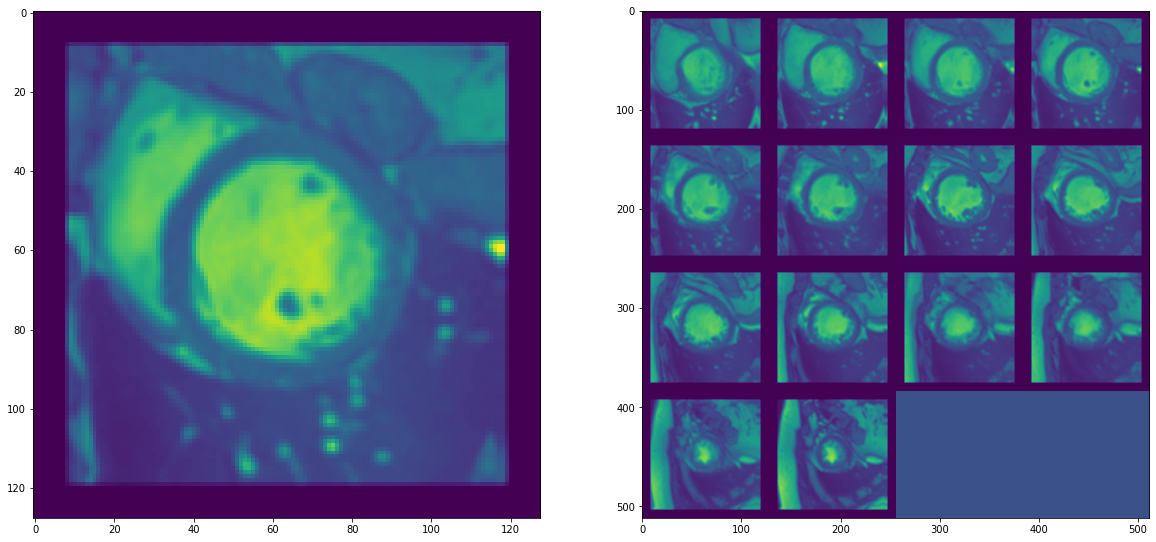

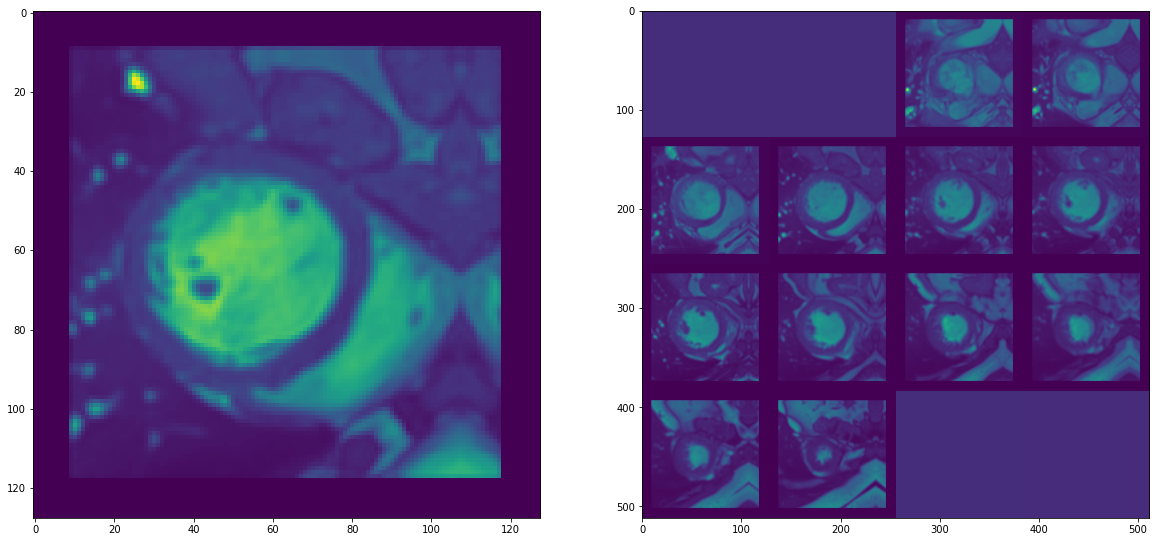

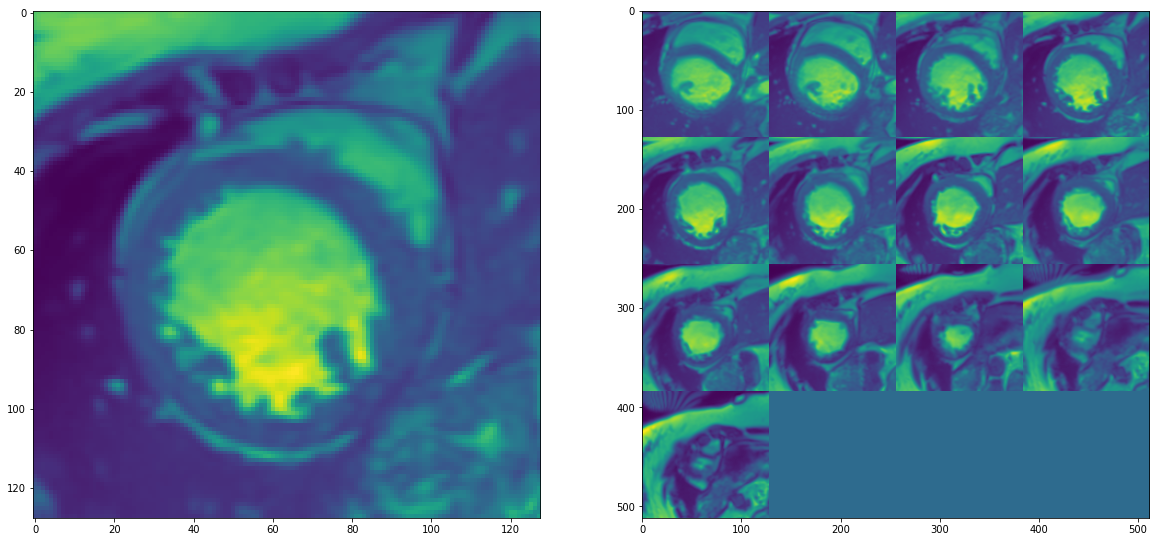

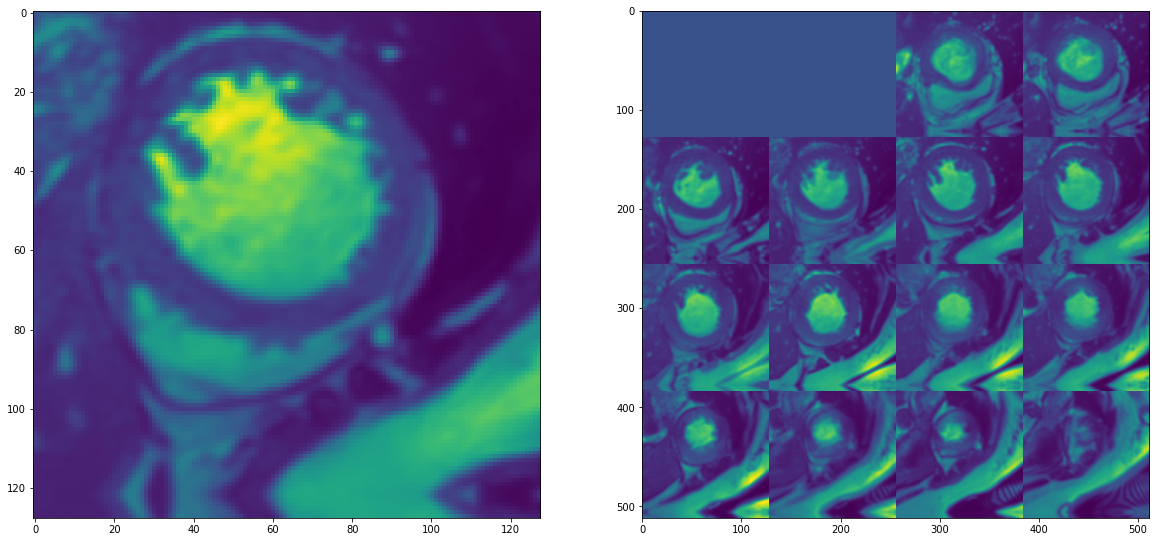

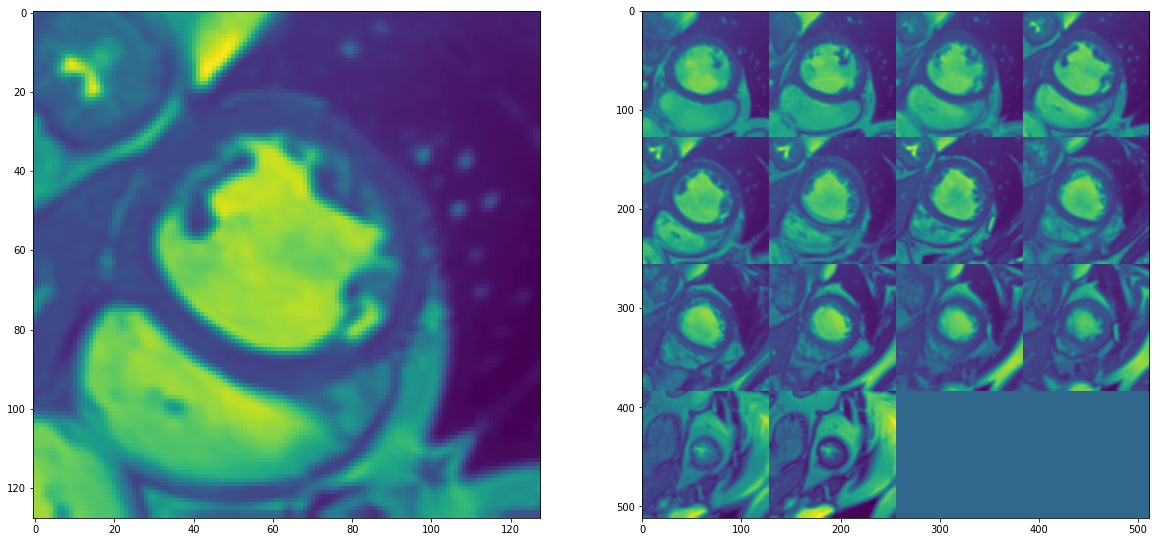

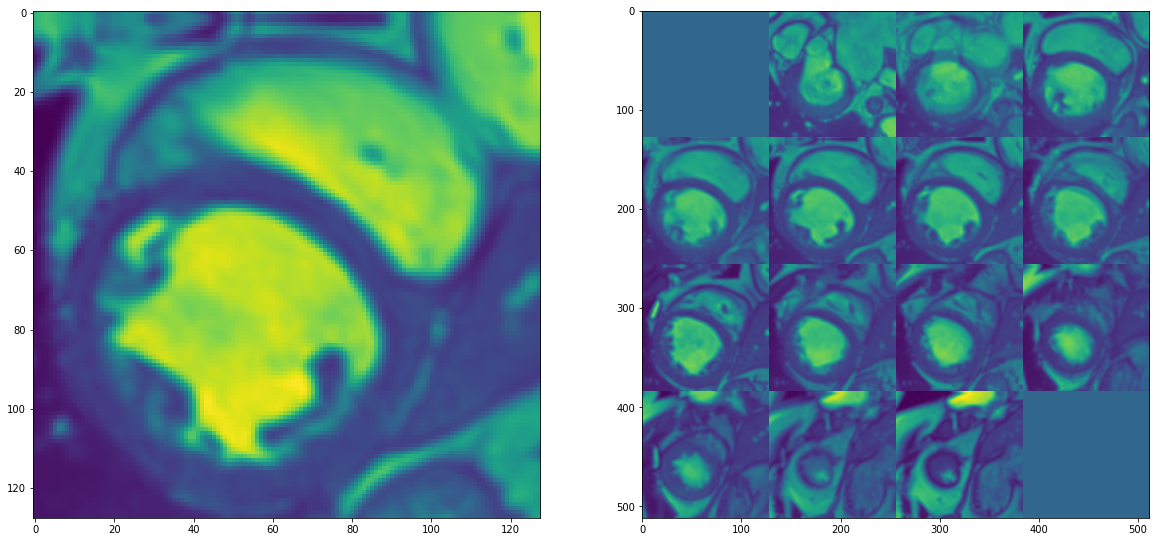

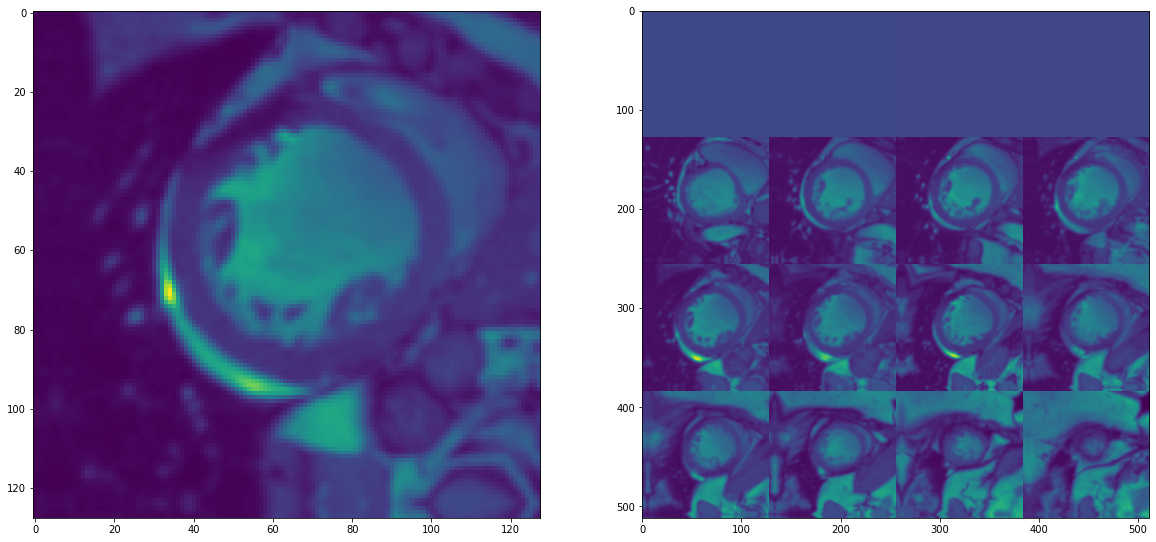

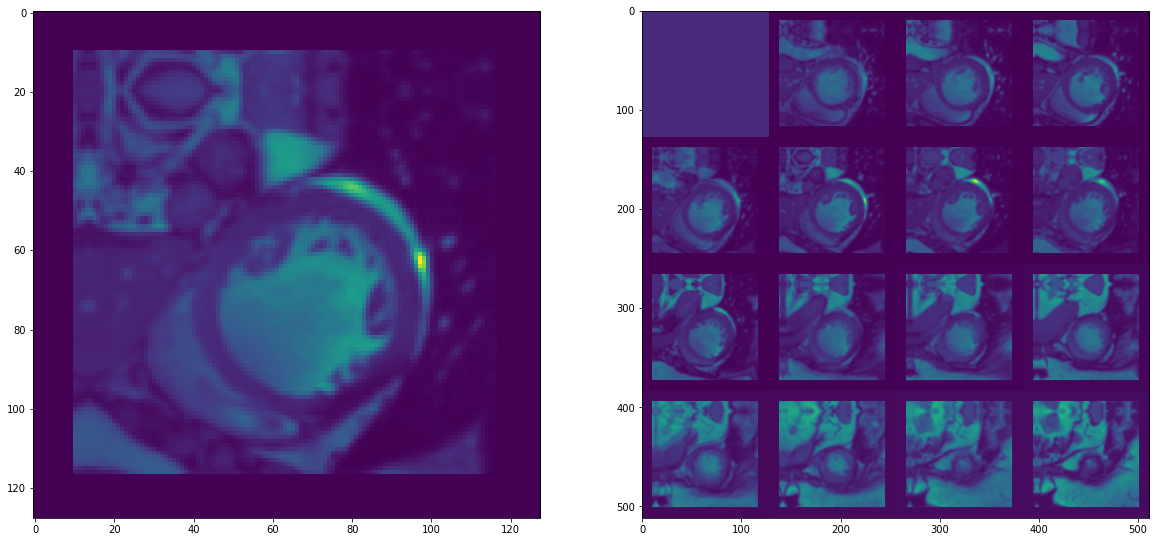

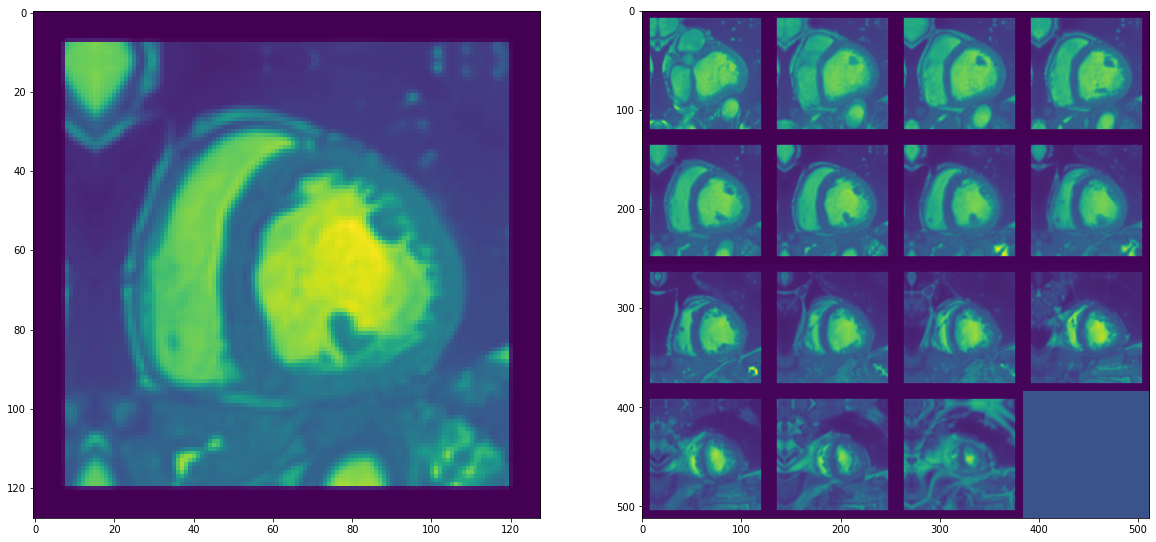

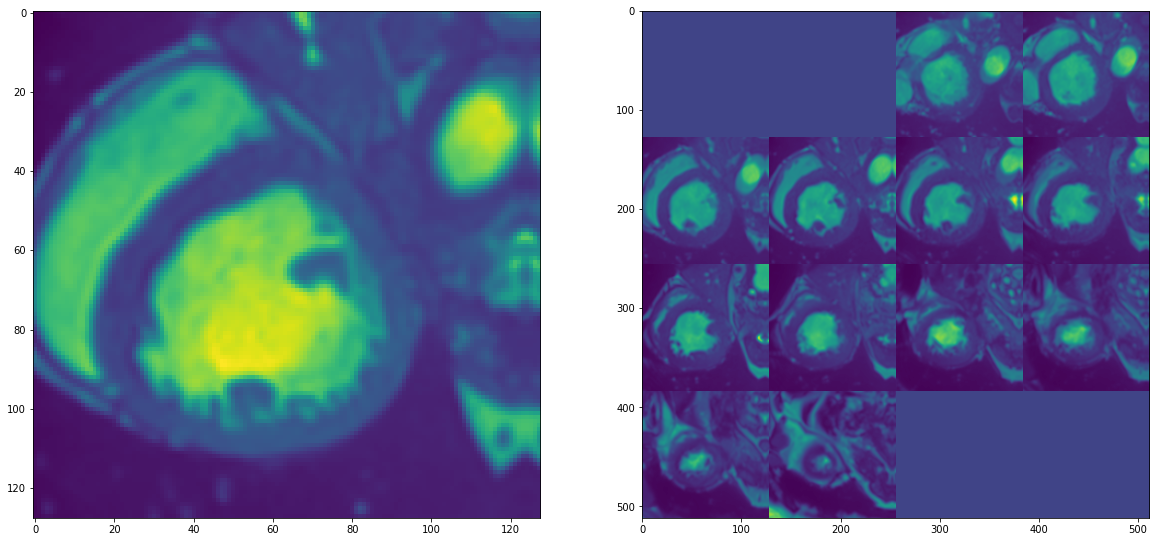

In [5]:
import matplotlib.pyplot as plt
from skimage.util import montage

dataset_ = dataset.filter(lambda x,y: tf.reduce_any(tf.not_equal(x['input_1'], x['input_2'])))
dataset_ = dataset.take(10)
dataset_ = dataset_.as_numpy_iterator()

for i,(x,y) in enumerate(dataset_):
    # plot 2 images
    # centers = center_of_mass3d(y[:,3])
    # print(centers)
    # warped = random_warp_mt(y[:,3]).numpy()
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(y[0,0,...,5,0])
    # ax[0].imshow(montage(y[0,3,...,0].transpose(2,0,1)).astype(np.int32))
    # ax[1].imshow(montage(warped[0,...,0].transpose(2,0,1)).astype(np.int32))

    warped = random_warp_t(y[:,1]).numpy()
    # fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    # ax[1].imshow(montage(y[0,1,...,0].transpose(2,0,1)))
    ax[1].imshow(montage(warped[0,...,0].transpose(2,0,1)))
    # ax[1].imshow(tf.cast(y[0,2,...,5,0], tf.int32) == 2, alpha=1)
    #fig.colorbar(ax[0].imshow(y[0,2,:,:,5,0]))
    # ax[1].imshow(tf.cast(y[0,3,...,5,0], tf.int32) == 2, cmap='gray', alpha=0.5)
    

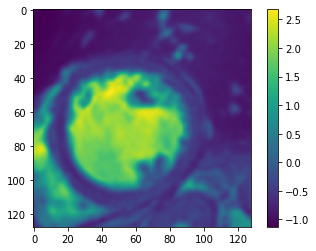

In [87]:
plt.imshow(original_y[0,:,:,0])
plt.colorbar()

In [5]:
V = np.stack(([1,], [2,]), axis=-1)
V

array([[1, 2]])

In [ ]:
import matplotlib.pyplot as plt

dataset = dataset.as_numpy_iterator()

for i,(x,y) in enumerate(dataset):
    plt.figure()
    plt.imshow(x['input_1'][0,...,5,0])
    plt.figure()
    plt.imshow(x['input_2'][0,...,5,0])
    plt.figure()
    plt.imshow(y[0,0,...,5,0])
    plt.figure()
    plt.imshow(y[0,1,...,5,0])
    plt.figure()
    plt.imshow(y[0,2,...,5,0])
    plt.figure()
    plt.imshow(y[0,3,...,5,0])
    plt.figure()
    plt.imshow(y[0,4,...,5,0])
    plt.figure()